## Import library

fast.ai 
Practical Deep Learning for Coders 

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.optimizers as opt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input

## Define path & total number

In [2]:
path = "..\\img\\cat"
dirlist = os.listdir(path)
catPath = [os.path.join(path, dirname) for dirname in dirlist]
# path_noncat = os.path.join(path, 'no_cat')


# train_dir = 'C:/Users/cs623/.keras/datasets/cats_and_dogs_filtered/train'
# validation_dir = 'C:/Users/cs623/.keras/datasets/cats_and_dogs_filtered/validation'
# train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
# train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
# validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
# validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [3]:
total_img_num = sum(map(len,map(os.listdir, catPath)))
print('all kinds of cats: ', dirlist)
for i in range(len(catPath)):
    print(dirlist[i], ': ', len(os.listdir(catPath[i])))
print('total cat imgs: ', total_img_num)

all kinds of cats:  ['喜马拉雅猫', '奶牛猫', '孟买猫', '布偶猫', '扁脸加菲猫', '折耳猫', '暹罗猫', '橘猫', '玫瑰纹豹猫', '缅因猫', '美短', '芬克斯猫', '蓝猫', '金渐层', '银渐层']
喜马拉雅猫 :  686
奶牛猫 :  1031
孟买猫 :  1078
布偶猫 :  1095
扁脸加菲猫 :  1294
折耳猫 :  1055
暹罗猫 :  1234
橘猫 :  1352
玫瑰纹豹猫 :  767
缅因猫 :  1049
美短 :  847
芬克斯猫 :  900
蓝猫 :  1174
金渐层 :  1346
银渐层 :  1327
total cat imgs:  16235


## Train test split

In [4]:
batch_size = 10
epochs = 20
IMG_HEIGHT = 116
IMG_WIDTH = 116
split = 0.2
classNum = len(dirlist)
total_val = total_img_num * split
total_train = total_img_num * (1 - split)

In [5]:
# Generator

train_datagen = ImageDataGenerator(
    rescale=1./255,rotation_range=40, # Angle, 0-180
    width_shift_range=0.2, # horizontal shifting
    height_shift_range=0.2, # vertical shifting
    shear_range=0.2, # Shearing
    zoom_range=0.2, # Zooming
    horizontal_flip=True, # Flipping
    validation_split=split
)

In [6]:
# Load images from the disk, applies rescaling, and resizes the images

train_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
) # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
) # set as validation data

Found 12994 images belonging to 15 classes.
Found 3241 images belonging to 15 classes.


In [7]:
print(validation_generator.class_indices)

{'喜马拉雅猫': 0, '奶牛猫': 1, '孟买猫': 2, '布偶猫': 3, '扁脸加菲猫': 4, '折耳猫': 5, '暹罗猫': 6, '橘猫': 7, '玫瑰纹豹猫': 8, '缅因猫': 9, '美短': 10, '芬克斯猫': 11, '蓝猫': 12, '金渐层': 13, '银渐层': 14}


## Samples

In [8]:
sample_img_train, sample_label_train = next(train_generator)

In [9]:
def plotImg(img):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for i, a in zip(img, axes):
        a.imshow(i)
        a.axis("off")
    plt.tight_layout()
    plt.show()

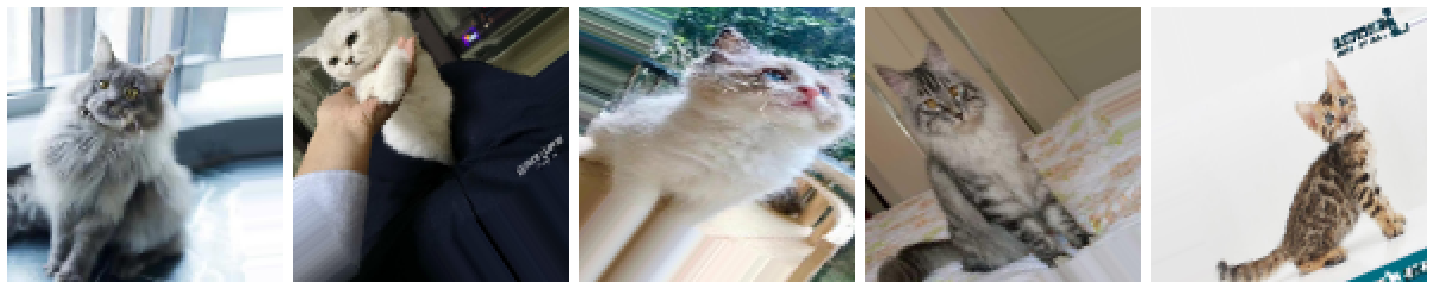

In [10]:
plotImg(sample_img_train[:15])

## Model

In [11]:
VGGNet = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), ),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    # Conv2D(256, 3, padding='same', activation='relu'),
    # Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(classNum, activation='softmax'),
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name = 'cov1'),
    Activation('relu', name = 'act1'),
    Conv2D(32, 3, name = 'cov2'),
    Activation('relu', name = 'act2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name = 'maxpool1'),
    Dropout(0.25, name = 'drop1'),
    Conv2D(64, 5, padding='same', name = 'cov3'),
    Activation('relu', name = 'act3'),
    Conv2D(64, 5, name = 'cov4'),
    Activation('relu', name = 'act4'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name = 'maxpool2'),
    Dropout(0.25, name = 'drop2'),
    Flatten(name = 'flatten'),
    Dense(512, name = 'dense1'),
    Activation('relu', name = 'act5'),
    Dropout(0.5, name = 'drop3'),
    Dense(classNum, name = 'dense2'),
    Activation('softmax', name = 'act6')
])
# 0.44-0.47 之间

In [13]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.8, nesterov=True)
rms = RMSprop(learning_rate=0.0001, decay=1e-6)

In [14]:
model.compile(optimizer=sgd,
             loss='categorical_crossentropy',
             metrics=['accuracy'],  
             )

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cov1 (Conv2D)                (None, 116, 116, 32)      896       
_________________________________________________________________
act1 (Activation)            (None, 116, 116, 32)      0         
_________________________________________________________________
cov2 (Conv2D)                (None, 114, 114, 32)      9248      
_________________________________________________________________
act2 (Activation)            (None, 114, 114, 32)      0         
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 57, 57, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 57, 57, 32)        0         
_________________________________________________________________
cov3 (Conv2D)                (None, 57, 57, 64)       

## Train model

In [16]:
def get_available_gpus():
    """
    code from http://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
    """
    from tensorflow.python.client import device_lib as _device_lib
    local_device_protos = _device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

In [17]:
model.load_weights('../multiclass/f_3355_60.120_weights_1.h5')

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
get_available_gpus()

['/device:CPU:0', '/device:GPU:0']

In [19]:
with tf.device('/gpu:0'):
    model.load_weights('../multiclass/f_3355_60.120_weights_1.h5')
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = total_train // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = total_val // batch_size     
    )
model.save_weights('../multiclass/f_3355_60.140_weights_1.h5')
# model.save('3355_1.h5')
model.save('../multiclass/f_3355_60.140.h5')

Epoch 1/20
1298/1298 [==============================] - 112s 86ms/step - loss: 1.7047 - acc: 0.4686 - val_loss: 1.8805 - val_acc: 0.4370
Epoch 2/20
1298/1298 [==============================] - 102s 79ms/step - loss: 1.6962 - acc: 0.4692 - val_loss: 1.9018 - val_acc: 0.4309
Epoch 3/20
1298/1298 [==============================] - 104s 80ms/step - loss: 1.6941 - acc: 0.4748 - val_loss: 1.9462 - val_acc: 0.4139
Epoch 4/20
1298/1298 [==============================] - 108s 83ms/step - loss: 1.6798 - acc: 0.4774 - val_loss: 1.9109 - val_acc: 0.4238
Epoch 5/20
1298/1298 [==============================] - 111s 86ms/step - loss: 1.6780 - acc: 0.4716 - val_loss: 1.8975 - val_acc: 0.4321
Epoch 6/20
1298/1298 [==============================] - 110s 84ms/step - loss: 1.6792 - acc: 0.4800 - val_loss: 1.9061 - val_acc: 0.4275
Epoch 7/20
1298/1298 [==============================] - 106s 82ms/step - loss: 1.6614 - acc: 0.4817 - val_loss: 1.8761 - val_acc: 0.4417
Epoch 8/20
1298/1298 [===================

## Result visualisation 

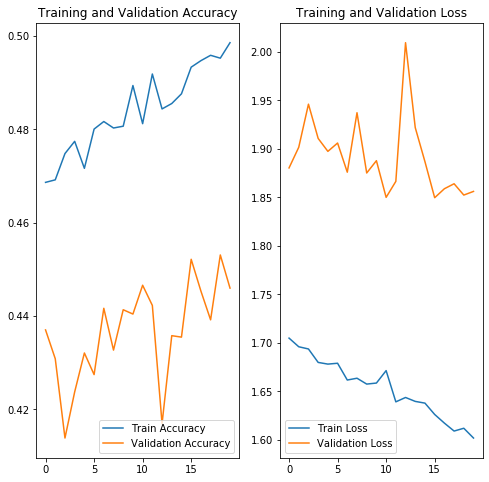

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
def InceptionNet():
    x_input = Input(shape = (116, 116, 3))
    x = Conv2D(32, 3, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3))(x_input)
    x = Activation('relu')(x)
    x = Conv2D(32,3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)

    x1 = Conv2D(64, 5, padding='same')(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(64, 5)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(64, 5, padding='same')(x)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(64, 5)(x2)
    x2 = Activation('relu')(x2)

    x = concatenate([x1, x2], axis = -1)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(521)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(classNum)(x)
    x = Activation('softmax')(x)

    model = Model(inputs = x_input, outputs = x, name = 'tryInception')
    return model

In [22]:
incep = InceptionNet()

In [23]:
incep.compile(optimizer=sgd,
             loss='categorical_crossentropy',
             metrics=['accuracy'],  
             )
incep.summary()

Model: "tryInception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 116, 116, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 116, 116, 32) 0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 114, 114, 32) 9248        activation[0][0]                 
_______________________________________________________________________________________

In [24]:
plot_model(incep, 'simplified_inception.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [25]:
with tf.device('/gpu:0'):
    history = incep.fit_generator(
        train_generator,
        steps_per_epoch = total_train // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = total_val // batch_size     
    )

Epoch 1/20
 248/1298 [====>.........................] - ETA: 1:28 - loss: 2.6913 - acc: 0.0859

KeyboardInterrupt: 

In [ ]:
incep.save_weights('./multiclass/incp_3355_120_weights.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()